In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# %matplotlib widget

def get_file_path(isotope: str, temp: float | str, ch: int, hv: int, dir: str):
    temp_str = temp if isinstance(temp, str) else f'{int(temp)}'
    return f"../data/{dir}/{isotope}/t_{temp_str}/ch_{ch}/hv_{hv}.csv"

def load_spec(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    
    df = pd.read_csv(filepath)
    exp_times = df.values[:, 0]
    total_exposure = np.sum(exp_times)
    spec_exposures = df.values[:, 4:]
    spec = np.sum(spec_exposures * np.tile(exp_times, (spec_exposures.shape[1], 1)).T, axis=0) / total_exposure
    return spec

def load_partial_specs(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    total_exposure = np.sum(df.values[:, 0])
    spec_exposures = df.values[:, 4:]
    return spec_exposures

channels = np.arange(0, 256)

## Reference calibration

For t = 20°C

### Am241

First spectral line - combination of 3 spectral lines

[ 0.10053875 40.44226555]


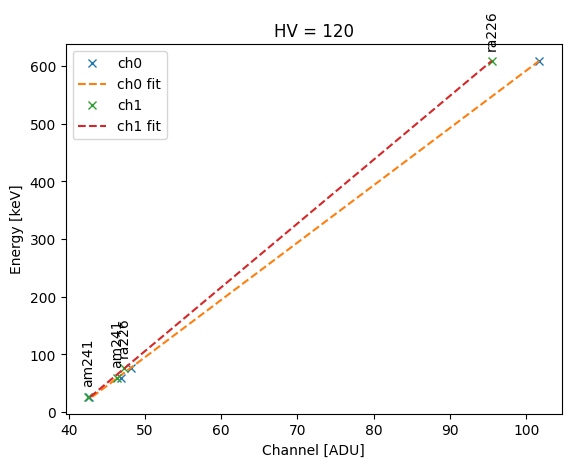

[ 0.13290042 41.19260551]


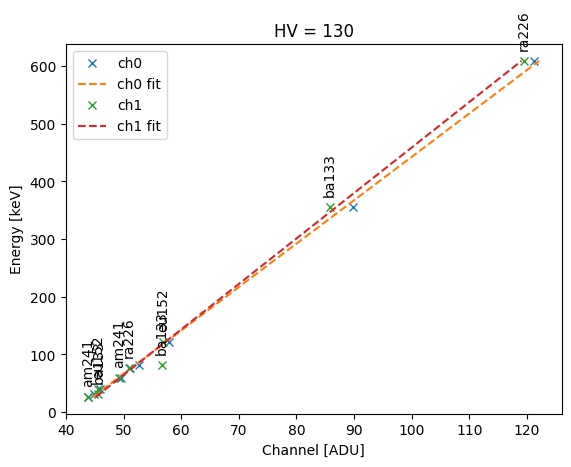

[ 0.16162677 42.1755856 ]


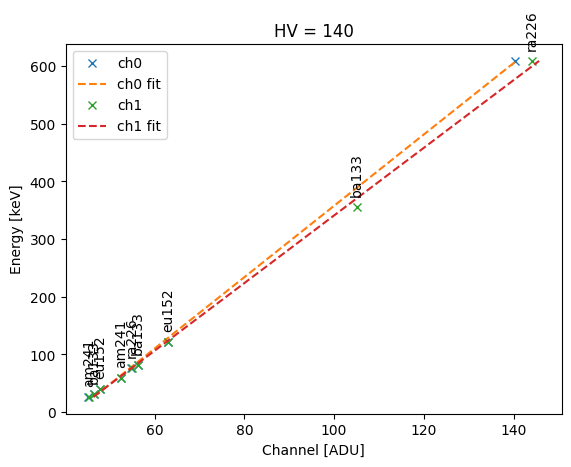

[ 0.21224126 42.16831139]


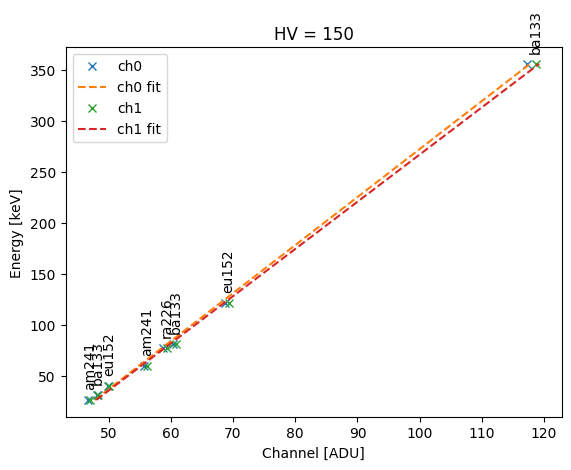

[ 0.28655762 41.33282429]


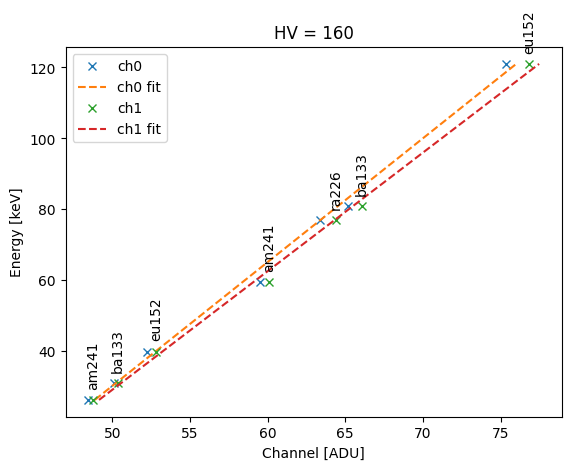

[ 0.34414994 41.64033674]


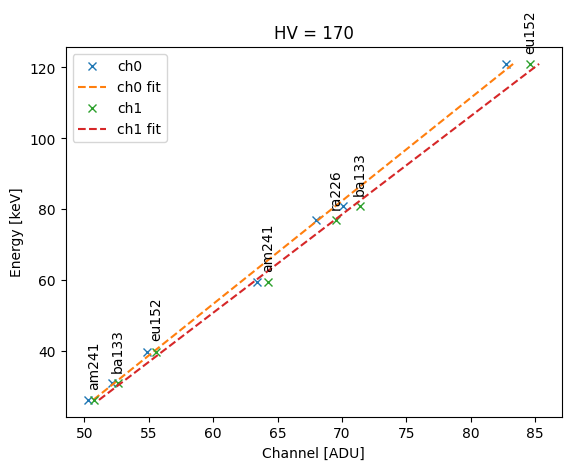

[ 0.41196064 41.88991877]


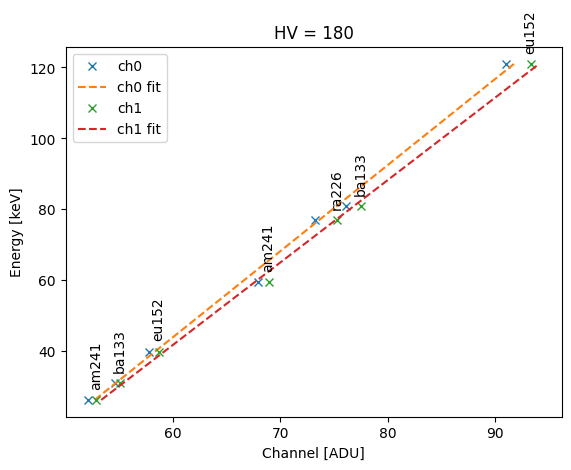

[ 0.50886664 41.20835371]


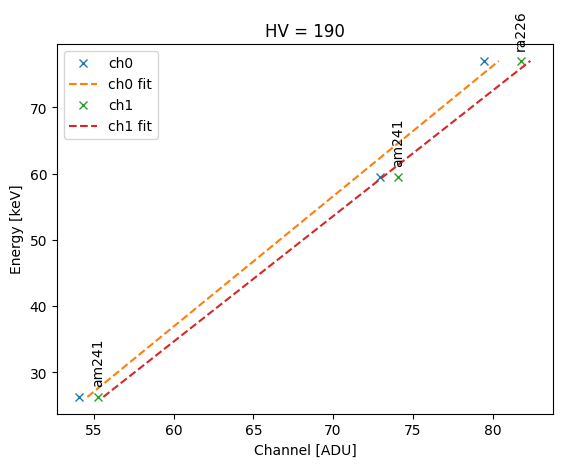

In [2]:
hvcalib_df = pd.read_csv("../data/peaks/hvcalib.csv")

hvs = hvcalib_df["hv"].values
energies = hvcalib_df["energy"].values
channels = hvcalib_df["channel"].values
chs = hvcalib_df["ch"].values
isotopes = hvcalib_df["isotope"].values

hvcal_hvs = np.arange(120, 191, 10)

hvcal0_ks = []
hvcal0_ch0s = []
hvcal0_ks_err = []
hvcal0_ch0s_err = []
hvcal1_ks = []
hvcal1_ch0s = []
hvcal1_ks_err = []
hvcal1_ch0s_err = []

for hv in hvcal_hvs:
    hv_filter = hvs == hv
    ch0_filter = chs == 0
    ch1_filter = chs == 1
    ra_filter = isotopes != "ra226"

    ch0_filter_all = hv_filter & ch0_filter# & ra_filter
    ch1_filter_all = hv_filter & ch1_filter# & ra_filter

    ch0_energies = energies[ch0_filter_all]
    ch0_channels = channels[ch0_filter_all]
    ch1_energies = energies[ch1_filter_all]
    ch1_channels = channels[ch1_filter_all]
    
    isotopes_labels = isotopes[ch1_filter_all]


    # Linear fit
    ch0_fit, ch0_fit_cov = np.polyfit(ch0_energies, ch0_channels, 1, cov=True)
    ch1_fit, ch1_fit_cov = np.polyfit(ch1_energies, ch1_channels, 1, cov=True)

    ch0_k = ch0_fit[0]
    ch0_ch0 = ch0_fit[1]
    ch1_k = ch1_fit[0]
    ch1_ch0 = ch1_fit[1]

    hvcal0_ks.append(ch0_k)
    hvcal0_ch0s.append(ch0_ch0)
    hvcal1_ks.append(ch1_k)
    hvcal1_ch0s.append(ch1_ch0)
    hvcal0_ks_err.append(np.sqrt(ch0_fit_cov[0, 0]))
    hvcal0_ch0s_err.append(np.sqrt(ch0_fit_cov[1, 1]))
    hvcal1_ks_err.append(np.sqrt(ch1_fit_cov[0, 0]))
    hvcal1_ch0s_err.append(np.sqrt(ch1_fit_cov[1, 1]))

    ch0_min = np.min(ch0_energies)
    ch0_max = np.max(ch0_energies)
    ch1_min = np.min(ch1_energies)
    ch1_max = np.max(ch1_energies)

    ch0_fit_Es = np.array([ch0_min, ch0_max])
    ch1_fit_Es = np.array([ch1_min, ch1_max])
    ch0_fit_chs = ch0_k * ch0_fit_Es + ch0_ch0
    ch1_fit_chs = ch1_k * ch1_fit_Es + ch1_ch0
    
    print(ch0_fit)
    plt.figure()
    plt.title(f"HV = {hv}")
    plt.plot(ch0_channels, ch0_energies, "x", label="ch0")
    plt.plot(ch0_fit_chs, ch0_fit_Es, '--', label="ch0 fit")
    plt.plot(ch1_channels, ch1_energies, "x", label="ch1")
    plt.plot(ch1_fit_chs, ch1_fit_Es, '--', label="ch1 fit")
    for i in range(len(ch1_channels)):
        plt.annotate(isotopes_labels[i], (ch1_channels[i], ch1_energies[i]), textcoords="offset points", xytext=(0, 10), ha='center', rotation=90)
    plt.xlabel("Channel [ADU]")
    plt.ylabel("Energy [keV]")
    plt.legend()
    plt.savefig(f"../outputs/hv-calib/hv_{hv}.png", dpi=400)
    plt.show()

hvcal0_ks = np.array(hvcal0_ks)
hvcal0_ch0s = np.array(hvcal0_ch0s)
hvcal1_ks = np.array(hvcal1_ks)
hvcal1_ch0s = np.array(hvcal1_ch0s)

# Save calibration data
calib_data = {
    "hv": hvcal_hvs,
    "ch0_k": hvcal0_ks,
    "ch0_E0": hvcal0_ch0s,
    "ch1_k": hvcal1_ks,
    "ch1_chi0": hvcal1_ch0s,
    "ch0_chi_err": hvcal0_ks_err,
    "ch0_chi0_err": hvcal0_ch0s_err,
    "ch1_k_err": hvcal1_ks_err,
    "ch1_chi0_err": hvcal1_ch0s_err
}

calib_df = pd.DataFrame(calib_data)
calib_df.to_csv("../outputs/hv-calib-data.csv", index=False)


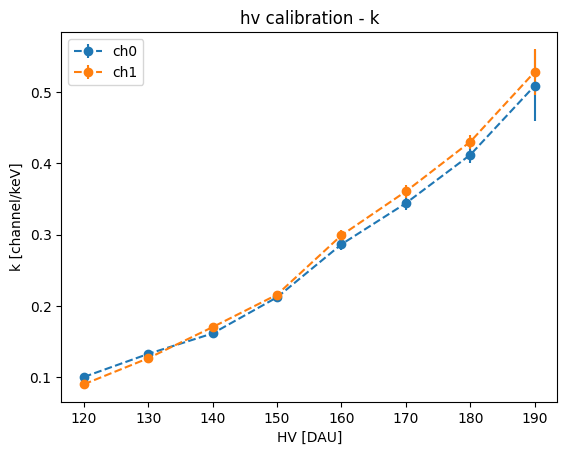

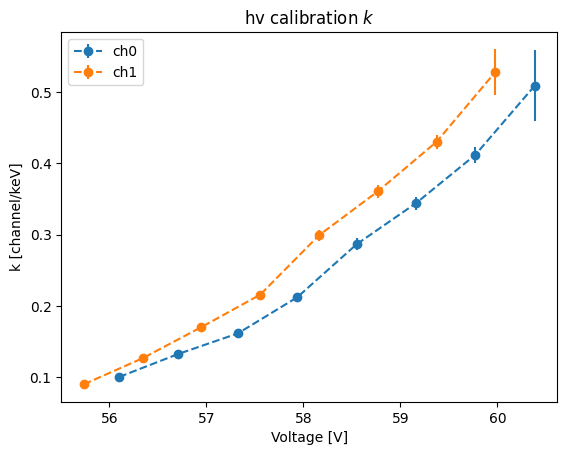

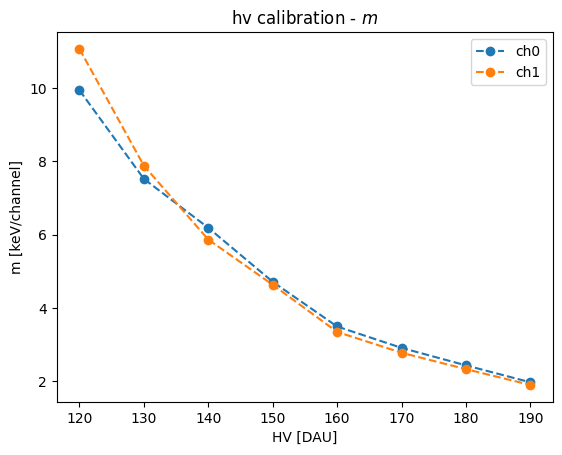

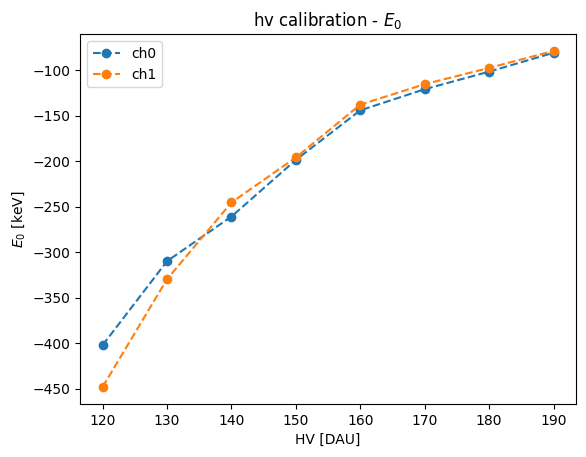

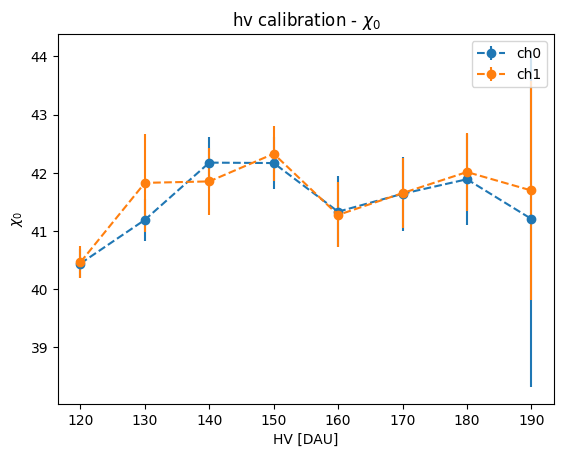

In [3]:
plt.figure()
plt.title("hv calibration - k")
plt.errorbar(hvcal_hvs, hvcal0_ks, linestyle='--', marker='o', yerr=hvcal0_ks_err, label="ch0")
plt.errorbar(hvcal_hvs, hvcal1_ks, linestyle='--', marker='o', yerr=hvcal1_ks_err, label="ch1")
plt.xlabel("HV [DAU]")
plt.ylabel("k [channel/keV]")
plt.legend()
plt.savefig("../outputs/hv-calib/hvcalib_k.pdf", dpi=400)
plt.show()

hv_voltage_ch0_c0 = 0.06121
hv_voltage_ch0_c1 = 48.755
hv_voltage_ch1_c0 = 0.06062
hv_voltage_ch1_c1 = 48.462
hvcal_voltages_ch0 = np.array(hvcal_hvs) * hv_voltage_ch0_c0 + hv_voltage_ch0_c1
hvcal_voltages_ch1 = np.array(hvcal_hvs) * hv_voltage_ch1_c0 + hv_voltage_ch1_c1

plt.figure()
plt.title("hv calibration $k$")
plt.errorbar(hvcal_voltages_ch0, hvcal0_ks, yerr=hvcal0_ks_err, linestyle='--', marker='o', label="ch0")
plt.errorbar(hvcal_voltages_ch1, hvcal1_ks, yerr=hvcal1_ks_err, linestyle='--', marker='o', label="ch1")
plt.xlabel("Voltage [V]")
plt.ylabel("k [channel/keV]")
plt.legend()
plt.savefig("../outputs/hv-voltage-k-plot.pdf")
plt.show()


plt.figure()
plt.title("hv calibration - $m$")
plt.plot(hvcal_hvs, 1/hvcal0_ks, linestyle='--', marker='o', label="ch0")
plt.plot(hvcal_hvs, 1/hvcal1_ks, linestyle='--', marker='o', label="ch1")
plt.xlabel("HV [DAU]")
plt.ylabel("m [keV/channel]")
plt.legend()
plt.savefig("../outputs/hv-calib/hvcalib_m.pdf", dpi=400)
plt.show()

plt.figure()
plt.title(r"hv calibration - $E_0$")
hvcal0_E0s = -hvcal0_ch0s / hvcal0_ks
hvcal1_E0s = -hvcal1_ch0s / hvcal1_ks
plt.plot(hvcal_hvs, hvcal0_E0s, linestyle='--', marker='o', label="ch0")
plt.plot(hvcal_hvs, hvcal1_E0s, linestyle='--', marker='o', label="ch1")
plt.xlabel("HV [DAU]")
plt.ylabel(r"$E_0$ [keV]")
plt.legend()
plt.savefig("../outputs/hv-calib/hvcalib_E0.pdf", dpi=400)
plt.show()

plt.figure()
plt.title(r"hv calibration - $\chi_0$")
plt.errorbar(hvcal_hvs, hvcal0_ch0s, linestyle='--', marker='o', yerr=hvcal0_ch0s_err, label="ch0")
plt.errorbar(hvcal_hvs, hvcal1_ch0s, linestyle='--', marker='o', yerr=hvcal1_ch0s_err, label="ch1")
plt.xlabel("HV [DAU]")
plt.ylabel(r"$\chi_0$")
plt.legend()
plt.savefig("../outputs/hv-calib/hvcalib_chi0.pdf", dpi=400)
plt.show()

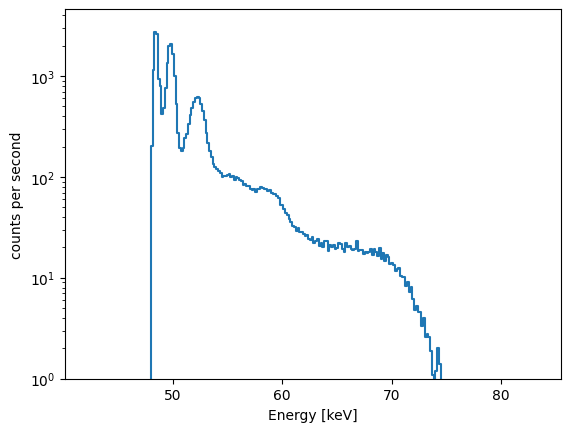

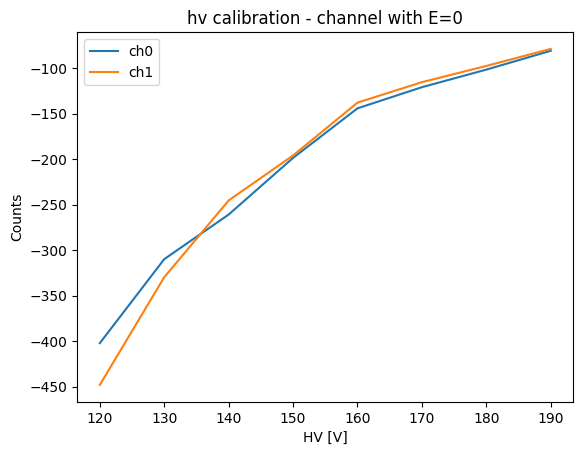

In [9]:
def ch0_ch2E(ch, hv):
    hv_idx = np.where(hvcal_hvs == hv)[0][0]
    return (hvcal0_ks[hv_idx] * ch + hvcal0_ch0s[hv_idx])

def ch1_ch2E(ch):
    return hvcal1_ks * ch + hvcal1_ch0s

def ch0_E2ch(E):
    return (E - hvcal0_ch0s) / hvcal0_ks

def ch1_E2ch(E):
    return (E - hvcal1_ch0s) / hvcal1_ks

hv_idx = np.where(hvcal_hvs == 130)[0][0]

ch0_E2ch(46)[hv_idx]

hv = 140
eu_spec = load_spec("eu152", 20, 0, hv, 'prague')
eu_energies = ch0_ch2E(np.arange(256), hv)

background_spec = load_spec("background", 20, 0, hv, 'prague')

plt.figure()
plt.step(eu_energies, eu_spec)
# plt.step(eu_energies, background_spec)
# plt.step(np.arange(256), eu_spec)
plt.xlabel("Energy [keV]")
# plt.xlabel("channel")
plt.ylabel("counts per second")
plt.yscale('log')
plt.ylim(1, None)
plt.show()

plt.figure()
plt.title("hv calibration - channel with E=0")
plt.plot(hvcal_hvs, ch0_E2ch(0), label="ch0")
plt.plot(hvcal_hvs, ch1_E2ch(0), label="ch1")
plt.xlabel("HV [V]")
plt.ylabel("Counts")
plt.legend()
plt.show()

## Temperature

Note: all Cs137 peaks for 32 keV were clearly picked incorrectly. Deleted them for now, but clearly needs further inspection

In [13]:
hvcalib_df = pd.read_csv("../data/peaks/temp.csv")

hvs = hvcalib_df["hv"].values
energies = hvcalib_df["energy"].values
channels = hvcalib_df["channel"].values
chs = hvcalib_df["ch"].values
isotopes = hvcalib_df["isotope"].values
temps = hvcalib_df["temp"].values

tcal_ks = []
tcal_ch0s = []
tcal_temps = []
tcal_hvs = []
tcal_ks_err = []
tcal_ch0s_err = []
# ch1_ms = []
# ch1_E0s = []
# ch1_ms_err = []
# ch1_E0s_err = []

calib_ts = np.arange(-10, 51, 5)
hvcal_hvs = np.arange(120, 191, 10)
for t in calib_ts:
    temp_filter = temps == t
    ch0_filter = chs == 0
    ch1_filter = chs == 1
    cs_32_filter = np.logical_not(np.logical_and(isotopes == "cs137", energies == 32.0))

    for hv in hvcal_hvs:
        hv_filter = hvs == hv

        ch0_filter_all = hv_filter & temp_filter & ch0_filter & cs_32_filter
        
        filtered_energies = energies[ch0_filter_all]
        filtered_channels = channels[ch0_filter_all]
        filtered_isotopes = isotopes[ch0_filter_all]

        if len(filtered_energies) < 3:
            continue

        # Linear fit
        fit, fit_cov = np.polyfit(filtered_energies, filtered_channels, 1, cov=True)

        k = fit[0]
        ch0 = fit[1]
        k_err = np.sqrt(fit_cov[0, 0])
        ch0_err = np.sqrt(fit_cov[1, 1])

        tcal_ks.append(k)
        tcal_ch0s.append(ch0)
        tcal_temps.append(t)
        tcal_hvs.append(hv)
        tcal_ks_err.append(k_err)
        tcal_ch0s_err.append(ch0_err)

        # Plot
        min_E = np.min(filtered_energies)
        max_E = np.max(filtered_energies)
        fit_E = np.array([min_E, max_E])
        fit_ch = k * fit_E + ch0
        plt.figure()
        plt.title(f"Temp = {t}, HV = {hv}")
        plt.plot(filtered_channels, filtered_energies, "x")
        plt.plot(fit_ch, fit_E, '--')
        plt.xlabel("Channel")
        plt.ylabel("Energy [keV]")

        for i in range(len(filtered_channels)):
            plt.annotate(filtered_isotopes[i], (filtered_channels[i], filtered_energies[i]), textcoords="offset points", xytext=(0, 10), ha='center', rotation=90)

        plt.savefig(f"../outputs/temp-calib/t_{t}_hv_{hv}.png", dpi=400)
        # plt.show()
        plt.close()

tcal_ks = np.array(tcal_ks)
tcal_ch0s = np.array(tcal_ch0s)
tcal_temps = np.array(tcal_temps)
tcal_hvs = np.array(tcal_hvs)
tcal_ks_err = np.array(tcal_ks_err)
tcal_ch0s_err = np.array(tcal_ch0s_err)


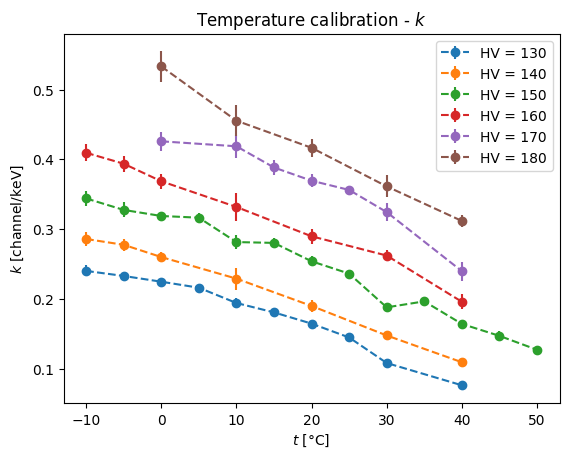

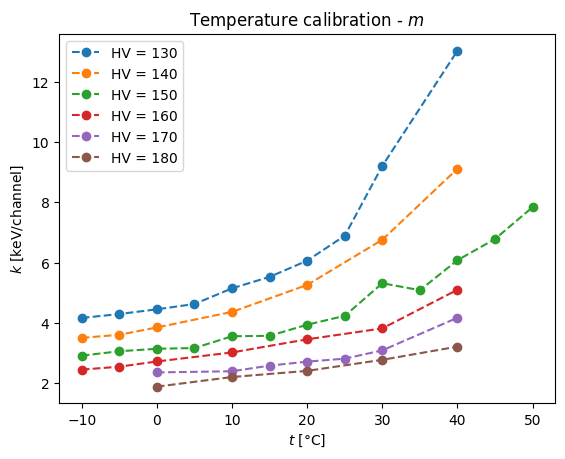

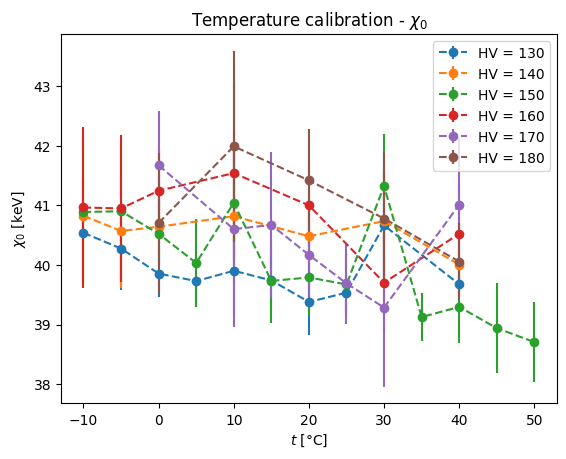

In [15]:
plt.figure()
plt.title("Temperature calibration - $k$")
for hv in np.arange(130, 181, 10):
    hv_filter = tcal_hvs == hv
    plt.errorbar(tcal_temps[hv_filter], tcal_ks[hv_filter], linestyle='--', marker='o', yerr=tcal_ks_err[hv_filter], label=f"HV = {hv}")

plt.xlabel("$t$ [°C]")
plt.ylabel("$k$ [channel/keV]")
plt.legend()
plt.savefig("../outputs/temp-calib/tcalib_k.pdf", dpi=400)
plt.show()

plt.figure()
plt.title("Temperature calibration - $m$")
for hv in np.arange(130, 181, 10):
    hv_filter = tcal_hvs == hv
    plt.plot(tcal_temps[hv_filter], 1/tcal_ks[hv_filter], '--o', label=f"HV = {hv}")

plt.ylabel("$k$ [keV/channel]")
plt.xlabel("$t$ [°C]")
plt.legend()
plt.savefig("../outputs/temp-calib/tcalib_m.pdf", dpi=400)
plt.show()

# plt.figure(figsize=(10, 8))
# plt.title("Temperature calibration - 1/m")
# for hv in np.arange(130, 181, 10):
#     hv_filter = ch0_hvs == hv
#     plt.plot(ch0_temps[hv_filter], 1/ch0_ms[hv_filter], label=f"HV = {hv}")

# plt.xlabel("Temperature [°C]")
# plt.ylabel("m [keV/channel]")
# plt.legend()
# # plt.savefig("./plots/temp-calib/m.png", dpi=400)
# plt.show()

# plt.figure()
# plt.title("Temperature calibration - log m")
# for hv in np.arange(130, 181, 10):
#     hv_filter = ch0_hvs == hv
#     plt.plot(ch0_temps[hv_filter], np.log(ch0_ms[hv_filter]), label=f"HV = {hv}")

# plt.xlabel("Temperature [°C]")
# plt.ylabel("m [keV/channel]")
# plt.legend()
# # plt.savefig("./plots/temp-calib/m.png", dpi=400)
# plt.show()
    
plt.figure()
plt.title(r"Temperature calibration - $\chi_0$")
for hv in np.arange(130, 181, 10):
    hv_filter = tcal_hvs == hv
    plt.errorbar(tcal_temps[hv_filter], tcal_ch0s[hv_filter], linestyle='--', marker='o', yerr=tcal_ch0s_err[hv_filter], label=f"HV = {hv}")

plt.xlabel(r"$t$ [°C]")
plt.ylabel(r"$\chi_0$ [keV]")
plt.legend()
plt.savefig("../outputs/temp-calib/tcalib_chi0.pdf", dpi=400)
plt.show()

temp_calib_data = {
    "hv": tcal_hvs,
    "temp": tcal_temps,
    "k": tcal_ks,
    "chi0": tcal_ch0s,
    "k_err": tcal_ks_err,
    "chi0_err": tcal_ch0s_err
}
df = pd.DataFrame(temp_calib_data)
df.to_csv("../outputs/temp-calib/calib_result.csv", index=False)

### hv animace

Saving frame 0 of 71
Saving frame 1 of 71
Saving frame 2 of 71
Saving frame 3 of 71
Saving frame 4 of 71
Saving frame 5 of 71
Saving frame 6 of 71
Saving frame 7 of 71
Saving frame 8 of 71
Saving frame 9 of 71
Saving frame 10 of 71
Saving frame 11 of 71
Saving frame 12 of 71
Saving frame 13 of 71
Saving frame 14 of 71
Saving frame 15 of 71
Saving frame 16 of 71
Saving frame 17 of 71
Saving frame 18 of 71
Saving frame 19 of 71
Saving frame 20 of 71
Saving frame 21 of 71
Saving frame 22 of 71
Saving frame 23 of 71
Saving frame 24 of 71
Saving frame 25 of 71
Saving frame 26 of 71
Saving frame 27 of 71
Saving frame 28 of 71
Saving frame 29 of 71
Saving frame 30 of 71
Saving frame 31 of 71
Saving frame 32 of 71
Saving frame 33 of 71
Saving frame 34 of 71
Saving frame 35 of 71
Saving frame 36 of 71
Saving frame 37 of 71
Saving frame 38 of 71
Saving frame 39 of 71
Saving frame 40 of 71
Saving frame 41 of 71
Saving frame 42 of 71
Saving frame 43 of 71
Saving frame 44 of 71
Saving frame 45 of 7

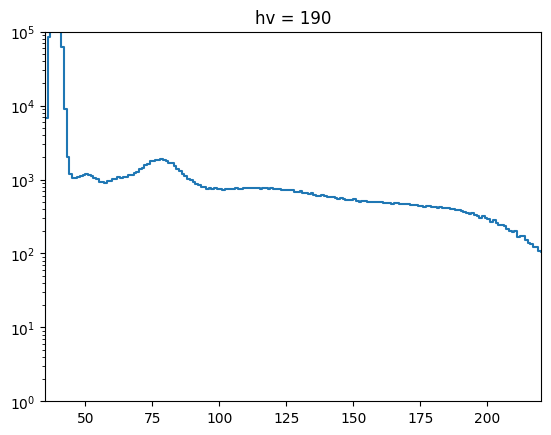

In [20]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_ylim(1, 1e5)
ax.set_xlim(35, 220)
channels = np.arange(0, 256)
line, = ax.step(channels, np.zeros(channels.shape[0]))

def update(frame):
    spec = load_spec('ra226', 'any', 0, frame, 'hv-vids')
    line.set_ydata(spec)

    # set title to hv
    ax.set_title(f'hv = {frame}')

    return line,

ani = FuncAnimation(fig, update, frames=range(120, 191, 1), blit=True)
ani.save('../outputs/ra226-hv-anim.mp4', fps=5, dpi=400, progress_callback=lambda i, n: print(f'Saving frame {i} of {n}'))
print("Done")